2025-05-06 05:01:34.948940: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 05:01:34.972650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-06 05:01:34.972675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-06 05:01:34.973476: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-06 05:01:34.977501: I tensorflow/core/platform/cpu_feature_guar

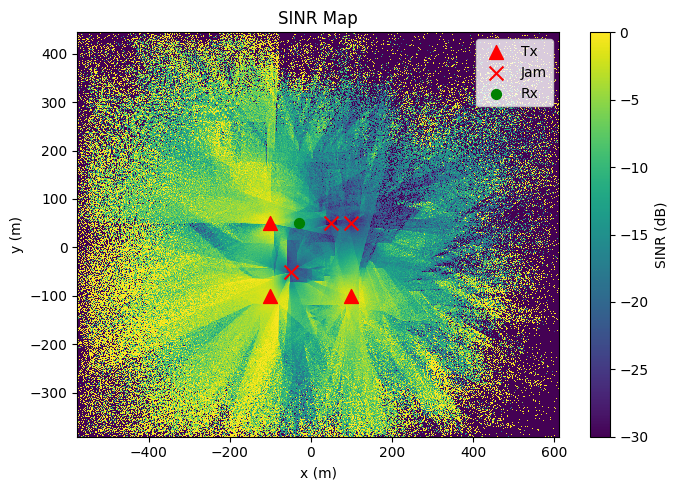

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, RadioMapSolver

# GPU housekeeping
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

# Parameters
SCENE_NAME = "GIS.xml"
TX_ARRAY_CONFIG = dict(num_rows=1, num_cols=1, vertical_spacing=0.5, horizontal_spacing=0.5, pattern="iso", polarization="V")
RX_ARRAY_CONFIG = TX_ARRAY_CONFIG
TX_LIST = [
    ("tx0", [-100, -100, 20], [np.pi*5/6, 0, 0], "desired", 30),
    ("tx1", [-100, 50, 20], [np.pi/6, 0, 0], "desired", 30),
    ("tx2", [100, -100, 20], [-np.pi/2, 0, 0], "desired", 30),
    ("jam1", [100, 50, 20], [np.pi/2, 0, 0], "jammer", 40),
    ("jam2", [50, 50, 20], [np.pi/2, 0, 0], "jammer", 40),
    ("jam3", [-50, -50, 20], [np.pi/2, 0, 0], "jammer", 40),
]
RX_CONFIG = ("rx", [-30, 50, 20])
RMSOLVER_ARGS = dict(max_depth=10, cell_size=(1., 1.), samples_per_tx=10**7)
SINR_VMIN = -40
SINR_VMAX = 0

# Scene setup
scene = load_scene(SCENE_NAME)
scene.tx_array = PlanarArray(**TX_ARRAY_CONFIG)
scene.rx_array = PlanarArray(**RX_ARRAY_CONFIG)

# Clear existing transmitters and receivers
for tx_name in list(scene.transmitters):
    scene.remove(tx_name)
for rx_name in list(scene.receivers):
    scene.remove(rx_name)

# Add transmitters
def add_tx(scene, name, pos, ori, role, power_dbm):
    tx = Transmitter(name=name, position=pos, orientation=ori, power_dbm=power_dbm)
    tx.role = role
    scene.add(tx)
    return tx

for name, pos, ori, role, p_dbm in TX_LIST:
    add_tx(scene, name, pos, ori, role, p_dbm)

# Add receiver
rx_name, rx_pos = RX_CONFIG
rx = Receiver(name=rx_name, position=rx_pos)
scene.add(rx)

# Group transmitters by role
all_txs = [scene.get(n) for n in scene.transmitters]
idx_des = [i for i, tx in enumerate(all_txs) if getattr(tx, 'role', None) == 'desired']
idx_jam = [i for i, tx in enumerate(all_txs) if getattr(tx, 'role', None) == 'jammer']

# Compute radio map
rm_solver = RadioMapSolver()
rm = rm_solver(scene, **RMSOLVER_ARGS)

# Calculate and plot SINR map
cc = rm.cell_centers.numpy()
x_unique = cc[0, :, 0]
y_unique = cc[:, 0, 1]
rss_list = [rm.rss[i].numpy() for i in range(len(all_txs))]
N0_map = 1e-12
rss_des = sum(rss_list[i] for i in idx_des)
rss_jam = sum(rss_list[i] for i in idx_jam)
sinr_db = 10 * np.log10(np.clip(rss_des / (rss_des + rss_jam + N0_map), 1e-12, None))

X, Y = np.meshgrid(x_unique, y_unique)
plt.figure(figsize=(7, 5))
pcm = plt.pcolormesh(X, Y, sinr_db, shading='nearest', vmin=SINR_VMIN+10, vmax=SINR_VMAX)
plt.colorbar(pcm, label="SINR (dB)")
plt.scatter([t.position[0] for t in all_txs if t.role == 'desired'],
            [t.position[1] for t in all_txs if t.role == 'desired'],
            c='red', marker='^', s=100, label='Tx')
plt.scatter([t.position[0] for t in all_txs if t.role == 'jammer'],
            [t.position[1] for t in all_txs if t.role == 'jammer'],
            c='red', marker='x', s=100, label='Jam')
plt.scatter(rx.position[0], rx.position[1], c='green', marker='o', s=50, label='Rx')
plt.legend()
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("SINR Map")
plt.tight_layout()
plt.show()